# Social Logistic Regression Models Using Merged Data Experiment 1.1

In [2]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import csv
import pickle
import warnings
import stanza

from random import shuffle
from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

# Set random seed
random.seed(18)
seed = 18

# Ignore warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_colwidth', None)

# Initialize lemmatizer, stop words, and stanza
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline


2024-10-09 01:06:38 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-10-09 01:06:38 INFO: Downloading default packages for language: en (English) ...
2024-10-09 01:06:39 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-10-09 01:06:42 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-10-09 01:06:42 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-10-09 01:06:42 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-10-09 01:06:43 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-10-09 01:06:43 INFO: Using device: cpu
2024-10-09 01:06:43 INFO: Loading: tokenize
2024-10-09 01:06:43 INFO: Loading: mwt
2024-10-09 01:06:43 INFO: Loading: pos
2024-10-09 01:06:44 INFO: Loading: lemma
2024-10-09 01:06:44 INFO: Loading: constituency
2024-10-09 01:06:44 INFO: Loading: depparse
2024-10-09 01:06:44 INFO: Loading: sentiment
2024-10-09 01:06:44 INFO: Loading: 

## 1. Loading the data and quick exploratory data analysis

In [3]:
merged_social_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Social_sentence_level_batch_1_jaccard.csv", encoding='utf-8')

# Shuffle the merged dataset
merged_social_df = shuffle(merged_social_df, random_state=seed)

# Train-test split 
training_df, test_df = train_test_split(merged_social_df, test_size=0.1, random_state=18, stratify=merged_social_df['label'])

training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [4]:
training_df.head()

,sentence,label,phrase
0,it does not hurt to get extra help and honestly it is an easy a that is one unit.,0,"['So, I scammed my friend to come with me to the first class because I did not want to go alone.']"
1,i want to go to med school and become a doctor.,0,"['I want to help people and connect to patients. I want to connect to the individual on a personal level and get to have a better relationship with them. I would love to be able to help people physically and mentally, while being a friend. I would love to work with elders and get to know them, their stories, and experiences.']"
2,a large amount of co2 is made by burning fossil fuels.,0,"['As most know right now, the environment is pretty fucked. From my standpoint, humanity needs to find a way to be less wasteful with their resources. Since using less is most likely not an option, I want to learn more about how electricity is produced and how it can be made more efficiently. A large amount of CO2 is made by burning fossil fuels. If we can reduce how much we use, then how much waste we produce is also cut down. That way we can reduce the amount of pollutants that we make and hopefully our race will live past the year 2100.']"
3,i believe i also will make an impact on climate change along with helping animals.,1,"['So as all over the place this whole write up was I believe I am here on this planet to live my life long dream of being part of the fashion industry, while making a positive impact environmentally', 'I believe I also will make an impact on Climate Change along with helping animals.']"
4,maybe i don't know.,0,['Our professor makes this class really enjoyable and hes really helpful.']


In [5]:
test_df.head()

,sentence,label,phrase
0,i have heard that the course itself is intense.,0,['I think sci would definitely enhance my learning abilities but also my academic selfesteem since I wont be the only student struggling with the subject.']
1,"but overall, mainly i want to make a difference in the medical community and use my skills to help others.",1,['mainly I want to make a difference in the medical community and use my skills to help others.']
2,"although there may be some courses in my curriculum that do not relate directly to my focus of study, they are prerequisites to the classes that will have more of a direct impact to my field of study.",0,"['Ultimately, I hope to get out as much as I can from my education in order to give back in the near future.']"
3,"it applies to just about everything in my daily life, especially subjects like math and science.",0,['Overall I see my education as a gateway to help others in need']
4,being here at san francisco state gives me an opportunity to get an education.,0,"['Secondly, I am here to make friends and experience new things.']"


In [6]:
print(f"Training dataset shape: {training_df.shape} \nTest dataset shape: {test_df.shape}")
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Training dataset shape: (1462, 3) 
Test dataset shape: (163, 3)
Positive labels present in the dataset : 166  out of 1462 or 11.354309165526676%
Positive labels present in the test dataset : 19  out of 163 or 11.65644171779141%


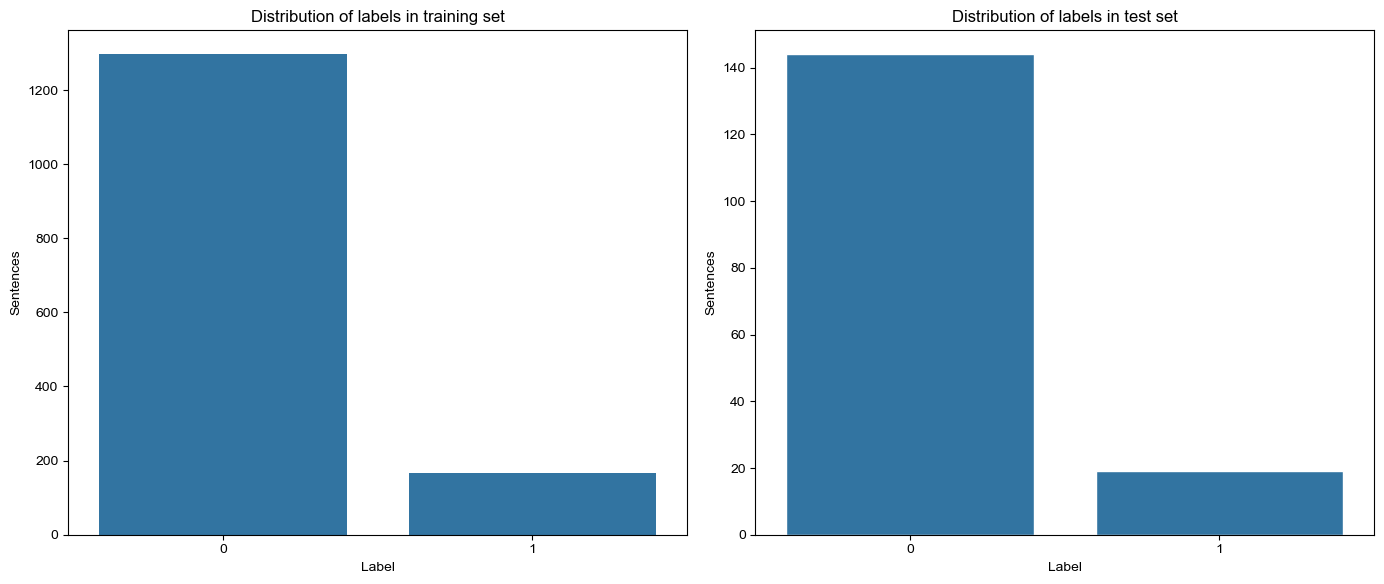

In [6]:
# Generate the data for the plots
training_counts = training_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the training set
sns.barplot(x=training_counts.index, y=training_counts.values, ax=axes[0])
axes[0].set_title('Distribution of labels in training set')
axes[0].set_ylabel('Sentences')
axes[0].set_xlabel('Label')
sns.set(style="whitegrid")

# Plot for the test set
sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1])
axes[1].set_title('Distribution of labels in test set')
axes[1].set_ylabel('Sentences')
axes[1].set_xlabel('Label')
sns.set(style="whitegrid")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## 2. Feature Engineering

### 1. NER

In [7]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [8]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

### 2. Similarity Features

In [9]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [10]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

### 3. Medical Word Count

In [11]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['microbiology', 'oncology', 'cardiology', 'chest', 'radiation', 'cardiothoracic', 'care', 'pathology', 'health', 'cytopathology', 'genetics', 'obstetrics', 'nuclear', 'neuromuscular', 'transfusion', 'segment', 'pediatrics', 'surgery', 'sports', 'psychiatry', 'dermatology', 'geriatric', 'molecular', 'research', 'pelvic', 'neurology', 'liaison', 'reconstructive', 'hospice', 'dermatopathology', 'dermatology', 'interventional', 'anatomical', 'neuro', 'pediatric', 'emergency', 'fetal', 'imaging', 'addiction', 'male', 'musculoskeletal', 'anterior', 'orbit', 'procedural', 'aerospace', 'surgical', 'adolescent', 'consultation', 'surgery', 'and', 'genetic', 'allergy', 'female', 'adolescent', 'cardiac', 'glaucoma', 'sports', 'plastic', 'oncology', 'infectious', 'physical', 'calculi', 'hematology', 'abdominal', 'neurodevelopmental', 'head', 'rehabilitation', 'genetic', 'internal', 'reproductive', 'critical', 'immunopathology', 'transplant', 'neurourology', 'advanced', 'heart', 'genitourinary', 'e

In [12]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

### 4. Sentiment Polarity and Subjectivity

In [13]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

### 5. POS Tag Count

In [14]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [15]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

### 6. Word Embeddings

In [16]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [17]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [18]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [19]:
# Function to split text into words
def split_into_words(text):
    return text.split()

### 7. Unigrams

In [20]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words = 'english')

### 8. Putting them all together

In [21]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [23]:
X_train, y_train = feature_engineering(training_df)

In [24]:
X_train.shape

(1462, 121)

In [25]:
y_train = y_train.astype('int')

In [23]:
X_test, y_test = feature_engineering(test_df)

In [27]:
X_test.shape

(163, 121)

In [28]:
y_test = y_test.astype('int')

**Calculate Unigram features for both train and test set**

In [29]:
X_train.shape

(1462, 121)

In [30]:
X_test.shape

(163, 121)

In [24]:
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Social/saved_features/X_test_final.csv", index=False)

In [31]:
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Social/saved_features/X_train_final.csv", index=False)
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Social/saved_features/X_test_final.csv", index=False)
y_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Social/saved_features/y_train.csv", index=False)
y_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Social/saved_features/y_test.csv", index=False)


In [32]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (1462, 1170)


In [33]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [34]:
X_train_final.columns = X_train_final.columns.astype(str)

In [35]:
X_train_final.shape

(1462, 1291)

In [36]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (163, 1170)


In [37]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(163, 1291)

In [39]:
X_test_final.columns = X_test_final.columns.astype(str)

In [40]:
X_test_final.shape

(163, 1291)

In [41]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [42]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:1291]]

In [43]:
X_train_model_1.shape

(1462, 1180)

In [44]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:1291]]

In [45]:
X_test_model_1.shape

(163, 1180)

In [46]:
model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.449
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9758    0.8403    0.9030       144
           1     0.4103    0.8421    0.5517        19

    accuracy                         0.8405       163
   macro avg     0.6930    0.8412    0.7274       163
weighted avg     0.9099    0.8405    0.8620       163



In [47]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 121, False Positive: 23, False Negative: 3, True Positive: 16
--------------------------------------------------------------------------------
[[121  23]
 [  3  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       144
           1       0.41      0.84      0.55        19

    accuracy                           0.84       163
   macro avg       0.69      0.84      0.73       163
weighted avg       0.91      0.84      0.86       163



### Model 2: All Features

In [49]:
# X_train_model_2 = X_train_final.iloc[:,np.r_[3:1113]]
X_train_model_2 = X_train_final.iloc[:, np.r_[3:1291]]

In [50]:
X_train_model_2.shape

(1462, 1288)

In [51]:
X_test_model_2 = X_test_final.iloc[:,np.r_[3:1291]]

In [52]:
X_test_model_2.shape

(163, 1288)

In [53]:
model_2_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_2,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.451
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9758    0.8403    0.9030       144
           1     0.4103    0.8421    0.5517        19

    accuracy                         0.8405       163
   macro avg     0.6930    0.8412    0.7274       163
weighted avg     0.9099    0.8405    0.8620       163



In [54]:
lr_model_2 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_2, y_train)
y_lr = lr_model_2.predict(X_test_model_2)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 121, False Positive: 23, False Negative: 3, True Positive: 16
--------------------------------------------------------------------------------
[[121  23]
 [  3  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       144
           1       0.41      0.84      0.55        19

    accuracy                           0.84       163
   macro avg       0.69      0.84      0.73       163
weighted avg       0.91      0.84      0.86       163



### Model 3: Without Unigrams

In [55]:
X_train_model_3 = X_train_final.iloc[:,np.r_[3:121]]

In [56]:
X_train_model_3.shape

(1462, 118)

In [57]:
X_test_model_3 = X_test_final.iloc[:,np.r_[3:121]]

In [58]:
X_test_model_3.shape

(163, 118)

In [59]:
model_3_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_3_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_3,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_3), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.389
Best parameters set:
	clf__C: 25
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9565    0.7639    0.8494       144
           1     0.2917    0.7368    0.4179        19

    accuracy                         0.7607       163
   macro avg     0.6241    0.7504    0.6337       163
weighted avg     0.8790    0.7607    0.7991       163



In [60]:
lr_model_3 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_3, y_train)
y_lr = lr_model_3.predict(X_test_model_3)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 110, False Positive: 34, False Negative: 5, True Positive: 14
--------------------------------------------------------------------------------
[[110  34]
 [  5  14]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       144
           1       0.29      0.74      0.42        19

    accuracy                           0.76       163
   macro avg       0.62      0.75      0.63       163
weighted avg       0.88      0.76      0.80       163



### Model 4: Without Embeddings

In [61]:
X_train_model_4 = X_train_final.iloc[:,np.r_[3:21,121:1291]]

In [62]:
X_train_model_4.shape

(1462, 1188)

In [63]:
X_test_model_4 = X_test_final.iloc[:,np.r_[3:21,121:1291]]

In [64]:
X_test_model_4.shape

(163, 1188)

In [66]:
model_4_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_4_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_4,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_4), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.456
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9756    0.8333    0.8989       144
           1     0.4000    0.8421    0.5424        19

    accuracy                         0.8344       163
   macro avg     0.6878    0.8377    0.7206       163
weighted avg     0.9085    0.8344    0.8573       163



In [67]:
lr_model_4 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_4, y_train)
y_lr = lr_model_4.predict(X_test_model_4)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 120, False Positive: 24, False Negative: 3, True Positive: 16
--------------------------------------------------------------------------------
[[120  24]
 [  3  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       144
           1       0.40      0.84      0.54        19

    accuracy                           0.83       163
   macro avg       0.69      0.84      0.72       163
weighted avg       0.91      0.83      0.86       163



### Model 5: Without POS Tag Count

In [68]:
X_train_model_5 = X_train_final.iloc[:,np.r_[3:13,21:1291]]

In [69]:
X_train_model_5.shape

(1462, 1280)

In [70]:
X_test_model_5 = X_test_final.iloc[:,np.r_[3:13,21:1291]]

In [71]:
X_test_model_5.shape

(163, 1280)

In [72]:
model_5_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_5_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_5,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_5), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.426
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       144
           1       0.44      0.74      0.55        19

    accuracy                           0.86       163
   macro avg       0.70      0.81      0.73       163
weighted avg       0.90      0.86      0.87       163



In [73]:
lr_model_5 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_5, y_train)
y_lr = lr_model_5.predict(X_test_model_5)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 126, False Positive: 18, False Negative: 5, True Positive: 14
--------------------------------------------------------------------------------
[[126  18]
 [  5  14]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       144
           1       0.44      0.74      0.55        19

    accuracy                           0.86       163
   macro avg       0.70      0.81      0.73       163
weighted avg       0.90      0.86      0.87       163



### Model 6: Without STEM Similarity

In [74]:
X_train_model_6 = X_train_final.iloc[:,np.r_[10:1291]]

In [75]:
X_train_model_6.shape

(1462, 1281)

In [76]:
X_test_model_6 = X_test_final.iloc[:,np.r_[10:1291]]

In [77]:
X_test_model_6.shape

(163, 1281)

In [78]:
model_6_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_6_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_6,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_6), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.442
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       144
           1       0.42      0.84      0.56        19

    accuracy                           0.85       163
   macro avg       0.70      0.84      0.73       163
weighted avg       0.91      0.85      0.87       163



In [79]:
lr_model_6 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_6, y_train)
y_lr = lr_model_6.predict(X_test_model_6)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 122, False Positive: 22, False Negative: 3, True Positive: 16
--------------------------------------------------------------------------------
[[122  22]
 [  3  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       144
           1       0.42      0.84      0.56        19

    accuracy                           0.85       163
   macro avg       0.70      0.84      0.73       163
weighted avg       0.91      0.85      0.87       163



### Model 7: Without Sentiment Features

In [80]:
X_train_model_7 = X_train_final.iloc[:,np.r_[3:10,12:1291]]

In [81]:
X_train_model_7.shape

(1462, 1286)

In [82]:
X_test_model_7 = X_test_final.iloc[:,np.r_[3:10,12:1291]]

In [83]:
X_test_model_7.shape

(163, 1286)

In [84]:
model_7_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_7_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_7,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_7), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.446
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       144
           1       0.42      0.84      0.56        19

    accuracy                           0.85       163
   macro avg       0.70      0.84      0.73       163
weighted avg       0.91      0.85      0.87       163



In [85]:
lr_model_7 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_7, y_train)
y_lr = lr_model_7.predict(X_test_model_7)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 122, False Positive: 22, False Negative: 3, True Positive: 16
--------------------------------------------------------------------------------
[[122  22]
 [  3  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       144
           1       0.42      0.84      0.56        19

    accuracy                           0.85       163
   macro avg       0.70      0.84      0.73       163
weighted avg       0.91      0.85      0.87       163



### Model 8: Without NER

In [86]:
X_train_model_8 = X_train_final.iloc[:,np.r_[3:12,13:1291]]

In [87]:
X_train_model_8.shape

(1462, 1287)

In [88]:
X_test_model_8 = X_test_final.iloc[:,np.r_[3:12,13:1291]]

In [89]:
X_test_model_8.shape

(163, 1287)

In [90]:
model_8_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_8_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_8,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_8), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.451
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       144
           1       0.41      0.84      0.55        19

    accuracy                           0.84       163
   macro avg       0.69      0.84      0.73       163
weighted avg       0.91      0.84      0.86       163



In [91]:
lr_model_8 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_8, y_train)
y_lr = lr_model_8.predict(X_test_model_8)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 121, False Positive: 23, False Negative: 3, True Positive: 16
--------------------------------------------------------------------------------
[[121  23]
 [  3  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       144
           1       0.41      0.84      0.55        19

    accuracy                           0.84       163
   macro avg       0.69      0.84      0.73       163
weighted avg       0.91      0.84      0.86       163



### Final Summary
| Experiment | Model Number | Features Used                                                | Precision | Recall | Macro F1 |
| :--------: | :----------: | :----------------------------------------------------------: | :-------: | :----: | :------: |
| Baseline   | 1            | Unigrams, POS Tag Count, Sentiment Polarity and Subjectivity | 0.69      | 0.84   | 0.73     |
| Baseline   | 2            | All features (baseline)                                      | 0.69      | 0.84   | 0.73     |
| Baseline   | 3            | Without Unigrams                                             | 0.62      | 0.75   | 0.63     |
| Baseline   | 4            | Without Embeddings                                           | 0.69      | 0.84   | 0.72     |
| Baseline   | 5            | Without POS tag                                              | 0.7       | 0.81   | 0.73     |
| Baseline   | 6            | Without STEM similarity (paper baseline)                     | 0.7       | 0.84   | 0.73     |
| Baseline   | 7            | Without sentiment features                                   | 0.7       | 0.84   | 0.73     |
| Baseline   | 8            | Without NER                                                  | 0.69      | 0.84   | 0.73     |